# Enunciado

Construir QA Bot basado en el ejemplo del traductor pero con un dataset QA.

Algunos frameworks/librerías que traen modelos e interfaces preparadas para armar rápidamente un sistema basado en NLP:

- DeepPavLov
- Hugging Face
- FastAI
- ParlAI

Recomendaciones:
- MAX_VOCAB_SIZE = 8000
- max_length ~ 10
- Embeddings 300 Fasttext
- n_units = 128
- LSTM Dropout 0.2
- Epochs 30~50

Preguntas interesantes:
- Do you read?
- Do you have any pet?
- Where are you from?

__IMPORTANTE__: Recuerde para la entrega del ejercicio debe quedar registrado en el colab las preguntas y las respuestas del BOT para que podamos evaluar el desempeño final.

# 1. Datos

## Importaciones

In [16]:
import re
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
import os
import pickle
import timeit

## Defino parametros recomendadas para el modelo

## Dataset

In [17]:
# Instalar la librería si no la tienes
!pip install datasets

from datasets import load_dataset

# Descargar el dataset wiki_qa
dataset = load_dataset("wiki_qa", split="train")


In [ ]:
# Convertir a pandas DataFrame para facilitar el manejo
import pandas as pd

df = pd.DataFrame(dataset)  # El split por defecto es 'train'

# Extraer listas de preguntas y respuestas
questions = df['question'].tolist()
answers = df['answer'].tolist()# Agrega tokens explícitos como <start> y <end> en las respuestas antes de la tokenización:
answers = ["<start> " + answer + " <end>" for answer in answers]

# Asegura que solo haya un <start> y un <end> por respuesta
def add_special_tokens(text):
    text = text.strip()
    text = text.replace('<start>', '').replace('<end>', '').strip()
    return f"<start> {text} <end>"

answers = [add_special_tokens(a) for a in answers]

# Calcular las longitudes de las preguntas
lengths_questions = [len(q.split()) for q in questions]
# Calcular el percentil 95 para cada tipo de secuencia
max_length_questions = int(np.percentile(lengths_questions, 95))
lengths_answers = [len(a.split()) for a in answers]
max_length_answers = int(np.percentile(lengths_answers, 95))

In [ ]:
MAX_VOCAB_SIZE = 8000 #baje desde 5000 para mejorar la precisión
#MAX_LENGTH = 12  # definida arriba con el percentil 95
EMBEDDING_DIM = 300  # FastText
N_UNITS = 128
LSTM_DROPOUT = 0.2
EPOCHS = 40  # Promedio recomendado

# Preprocesamiento

## Tokenización de preguntas y respuestas


In [20]:
#Vocabulario de entrada: 4083 palabras
#Vocabulario de salida: 32275 palabras

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

# Tokenizador para preguntas (inputs)
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
input_tokenizer.fit_on_texts(questions)
input_integer_seq = input_tokenizer.texts_to_sequences(questions)

word2idx_inputs = input_tokenizer.word_index
print("Palabras en el vocabulario (input):", len(word2idx_inputs))

max_input_len = max(len(seq) for seq in input_integer_seq)
print("Pregunta más larga:", max_input_len)

# Tokenizador para respuestas (outputs)
#output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!\"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
output_tokenizer = Tokenizer(
    num_words=MAX_VOCAB_SIZE, 
    filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n',  # Quita '<' y '>' de los filtros
    oov_token='<unk>'  # Opcional: token para palabras desconocidas
)

output_tokenizer.fit_on_texts(answers)
output_integer_seq = output_tokenizer.texts_to_sequences(answers)

word2idx_outputs = output_tokenizer.word_index
print("Palabras en el vocabulario (output):", len(word2idx_outputs))

max_output_len = max(len(seq) for seq in output_integer_seq)
print("Respuesta más larga:", max_output_len)

num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE)  # +1 para el token de palabra desconocida


Palabras en el vocabulario (input): 4082
Pregunta más larga: 23
Palabras en el vocabulario (output): 32274
Respuesta más larga: 167


## Padding de secuencias


In [21]:
# Limitar longitudes si es necesario
max_input_len = min(max_input_len, max_length_questions)
max_output_len = min(max_output_len, max_length_answers)

encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
decoder_input_sequences = pad_sequences(output_integer_seq, maxlen=max_output_len, padding='post')

print("encoder_input_sequences shape:", encoder_input_sequences.shape)
print("decoder_input_sequences shape:", decoder_input_sequences.shape)


encoder_input_sequences shape: (20360, 12)
decoder_input_sequences shape: (20360, 46)


## One-hot encoding de las salidas

In [22]:
from tensorflow.keras.utils import to_categorical

decoder_targets = to_categorical(decoder_input_sequences, num_classes=num_words_output)
print("decoder_targets shape:", decoder_targets.shape)


decoder_targets shape: (20360, 46, 3000)


## Descargar Fasttext

In [23]:
import os

if not os.path.exists("cc.en.300.vec"):
    if not os.path.exists("cc.en.300.vec.gz"):
        # Descargar solo si el archivo comprimido no existe
        !wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
    # Descomprimir solo si el archivo descomprimido no existe
    !gunzip cc.en.300.vec.gz
else:
    print("El archivo cc.en.300.vec ya existe, no se descarga ni descomprime.")

El archivo cc.en.300.vec ya existe, no se descarga ni descomprime.


# Preparear los embeddings

## Descargar y Descomprimir los Embeddings FastText

In [24]:
EMBEDDING_VEC_TXT = 'cc.en.300.vec'
EMBEDDING_VEC_PKL = 'cc.en.300.vec.pkl'

if os.path.exists(EMBEDDING_VEC_PKL):
    print("Cargando embeddings desde el archivo pickle...")
    with open(EMBEDDING_VEC_PKL, 'rb') as f:
        embedding_index = pickle.load(f)
else:
    print("Procesando archivo de texto de embeddings...")
    embedding_index = {}
    with open(EMBEDDING_VEC_TXT, encoding='utf-8', errors='ignore') as f:
        next(f)  # saltea la primera línea si tiene info de vocabulario
        for line in f:
            values = line.rstrip().split(' ')
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embedding_index[word] = vector
    # Guardar para la próxima vez
    with open(EMBEDDING_VEC_PKL, 'wb') as f:
        pickle.dump(embedding_index, f)
    print("Embeddings guardados en archivo pickle.")

print(f"Cantidad de palabras en embeddings: {len(embedding_index)}")

Cargando embeddings desde el archivo pickle...
Cantidad de palabras en embeddings: 2000000


## Crear la Embedding Matrix para el Encoder

In [25]:
nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs) + 1)
embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))

for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    # Si la palabra no está, la fila queda en ceros (vector nulo)


## Verificar la Embedding Matrix


In [26]:
print('embedding_matrix shape:', embedding_matrix.shape)
print('Número de palabras sin embedding:', np.sum(np.sum(embedding_matrix, axis=1) == 0))

embedding_matrix shape: (3000, 300)
Número de palabras sin embedding: 82


## Definición del Modelo Seq2Seq (Encoder-Decoder)


In [ ]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Dropout
from tensorflow.keras.models import Model

# Encoder
encoder_inputs = Input(shape=(max_input_len,))
encoder_embedding = Embedding(
    input_dim=nb_words,
    output_dim=EMBEDDING_DIM,
    #input_length=max_input_len,
    weights=[embedding_matrix],
    trainable=False
)(encoder_inputs)
encoder_lstm = LSTM(N_UNITS, return_state=True, dropout=LSTM_DROPOUT)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(max_output_len,))
decoder_embedding = Embedding(
    input_dim=num_words_output,
    output_dim=N_UNITS,
   # input_length=max_output_len
)(decoder_inputs)

# Decoder LSTM
decoder_lstm = LSTM(N_UNITS, return_sequences=True, return_state=True, dropout=LSTM_DROPOUT)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Modelo final
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 46)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 12, 300)   │    900,000 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 46, 128)   │    384,000 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 128),     │    219,648 │ embedding_2[0][0] │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, 46, 128), │    131,584 │ embedding_3[0][0… │
│                     │ (None, 128),      │            │ lstm_2[0][1],     │
│                     │ (None, 128)]      │            │ lstm_2[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 46, 3000)  │    387,000 │ lstm_3[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,022,232 (7.71 MB)

 Trainable params: 1,122,232 (4.28 MB)

 Non-trainable params: 900,000 (3.43 MB)

# Entrenamiento del modelo

In [28]:
## Entrenamos y guardamos el modelo

In [29]:
# Entrenar el modelo
hist = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets,
    batch_size=512,
    epochs=EPOCHS,  # Puedes ajustar entre 30 y 50 según recursos y overfitting
    validation_split=0.2
)
model.save('my_model.keras')

Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 601ms/step - accuracy: 0.4657 - loss: 6.6650 - val_accuracy: 0.5021 - val_loss: 3.1181
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 562ms/step - accuracy: 0.5229 - loss: 2.9882 - val_accuracy: 0.5962 - val_loss: 2.6288
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 595ms/step - accuracy: 0.5961 - loss: 2.5729 - val_accuracy: 0.6006 - val_loss: 2.4085
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 652ms/step - accuracy: 0.6001 - loss: 2.3797 - val_accuracy: 0.6270 - val_loss: 2.2567
Epoch 5/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 588ms/step - accuracy: 0.6348 - loss: 2.2329 - val_accuracy: 0.7013 - val_loss: 2.0834
Epoch 6/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 569ms/step - accuracy: 0.7064 - loss: 2.0635 - val_accuracy: 0.7364 - val_loss: 1.9150
Epoch 7/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 608ms/step - accuracy: 0.7355 - loss: 1.8940 - val_accuracy: 0.7516 - val_loss: 1.7876
Epoch 8/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 606ms/step - accuracy: 0.7524 - loss: 1.7795 - val_accu

## Visualización

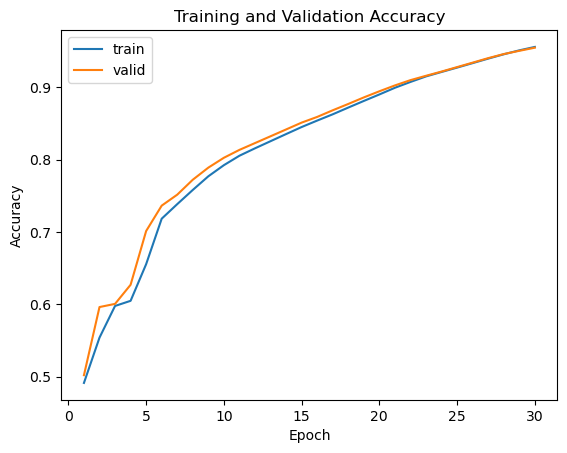

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count, y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count, y=hist.history['val_accuracy'], label='valid')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


# Prueba del modelo

## Defino el modelo del encoder y del decoder

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense

# Encoder de inferencia
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder de inferencia (correcciones clave)
decoder_state_input_h = Input(shape=(N_UNITS,), name='decoder_state_input_h')
decoder_state_input_c = Input(shape=(N_UNITS,), name='decoder_state_input_c')
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Redefinir la capa de embedding del decoder para inferencia
#decoder_embedding_infer = Embedding(
#    input_dim=num_words_output,  # Usar el tamaño del vocabulario de salida
#    output_dim=N_UNITS,          # Coincide con las unidades LSTM
#    input_length=1               # Solo un token por paso
#)

# Input del decoder: un solo token (shape=(1,))
#decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single = Input(shape=(1,), name='decoder_input_single')

# Get the trained layers
decoder_embedding_layer = model.get_layer(index=4) # Or by name if you add names
decoder_lstm_layer = model.get_layer(index=5)      # Or by name
decoder_dense_layer = model.get_layer(index=6)     # Or by name

#decoder_inputs_single_x = decoder_embedding_infer(decoder_inputs_single)
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

# Redefinir la LSTM del decoder para inferencia
#decoder_lstm_infer = LSTM(
#    N_UNITS, 
#    return_sequences=True, 
#    return_state=True, 
#    dropout=LSTM_DROPOUT
#)

decoder_outputs, state_h, state_c = decoder_lstm_layer(
    decoder_inputs_single_x, 
    initial_state=decoder_states_inputs
)

# Capa densa final (usar la misma del modelo original)
decoder_outputs = decoder_dense(decoder_outputs)

# Construir el modelo del decoder
decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs] + [state_h, state_c]
)


In [36]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Dropout
from tensorflow.keras.models import Model

# Encoder
encoder_inputs = Input(shape=(max_input_len,), name='encoder_input') # Add name
encoder_embedding = Embedding(
    input_dim=nb_words,
    output_dim=EMBEDDING_DIM,
    weights=[embedding_matrix],
    trainable=False,
    name='encoder_embedding' # Add name
)(encoder_inputs)
encoder_lstm = LSTM(N_UNITS, return_state=True, dropout=LSTM_DROPOUT, name='encoder_lstm') # Add name
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(max_output_len,), name='decoder_input') # Add name
decoder_embedding = Embedding(
    input_dim=num_words_output,
    output_dim=N_UNITS,
    name='decoder_embedding' # Add name
)(decoder_inputs)

# Decoder LSTM
decoder_lstm = LSTM(N_UNITS, return_sequences=True, return_state=True, dropout=LSTM_DROPOUT, name='decoder_lstm') # Add name
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(num_words_output, activation='softmax', name='decoder_dense') # Add name
decoder_outputs = decoder_dense(decoder_outputs)

# Modelo final
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_input       │ (None, 46)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding   │ (None, 12, 300)   │    900,000 │ encoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding   │ (None, 46, 128)   │    384,000 │ decoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, 128),     │    219,648 │ encoder_embeddin… │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, 46, 128), │    131,584 │ decoder_embeddin… │
│                     │ (None, 128),      │            │ encoder_lstm[0][… │
│                     │ (None, 128)]      │            │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense       │ (None, 46, 3000)  │    387,000 │ decoder_lstm[0][… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,022,232 (7.71 MB)

 Trainable params: 1,122,232 (4.28 MB)

 Non-trainable params: 900,000 (3.43 MB)

## Preparar los conversores de índices

In [38]:
idx2word_input = {v: k for k, v in word2idx_inputs.items()}
idx2word_output = {v: k for k, v in word2idx_outputs.items()}

## Función de inferencia (QA Bot)

In [39]:
def answer_question(question_text):
    # Tokenizar y paddear la pregunta
    seq = input_tokenizer.texts_to_sequences([question_text])
    seq = pad_sequences(seq, maxlen=max_input_len)
    
    # Obtener los estados del encoder
    states_value = encoder_model.predict(seq)
    
    # Inicializar secuencia de entrada al decoder con el token de inicio (por ejemplo, '')
    target_seq = np.zeros((1, 1))
    # Usar '<start>' como token de inicio
    target_seq[0, 0] = word2idx_outputs['<start>']

    # Usar '<end>' como token de fin
    eos = word2idx_outputs['<end>']  
    
    output_sentence = []
    for _ in range(max_output_len):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])
        if idx == eos:
            break
        word = idx2word_output.get(idx, '')
        output_sentence.append(word)
        # Actualizar estados y entrada
        states_value = [h, c]
        target_seq[0, 0] = idx
    return ' '.join(output_sentence)

## Probar las preguntas

In [40]:
test_questions = [
    "How can I reset my password?",
    "What payment methods do you accept?",
    "How do I update my account information?",
    "What is your privacy policy?",
    "Can I return a product if it was purchased as a gift?"
]

for q in test_questions:
    print("Q:", q)
    print("A:", answer_question(q))
    print("-" * 30)


Q: How can I reset my password?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━